In [ ]:
# using Revise
# path_to_package = "/home/manuel/.julia/dev/PauliPropagation"
# insert!(LOAD_PATH, 1, path_to_package);

using Pkg
Pkg.add(url="https://github.com/MSRudolph/PauliPropagation.jl.git", rev="dev")

    Updating git-repo `https://github.com/MSRudolph/PauliPropagation.jl.git`
   Resolving package versions...


In [54]:
using PauliPropagation

In [55]:
θ = 0.1im

0.0 + 0.1im

In [56]:
# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

In [131]:
nq = 6
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
# append!(circuit, TransferMapGate([ii], rzmap) for ii in 1:nq);
# append!(circuit, TransferMapGate(collect(pair), rzzmap) for pair in topology);

6-element Vector{Gate}:
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [1])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [2])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [3])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [4])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.1001667

In [132]:
nq = 6
pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)

PauliSum(nqubits: 6, 1 Pauli term: 
 1.0 * IIIIII
)

In [133]:
# # Manuel version

# nls = 1
# overlapsManuel = Float64[overlapwithplus(psum) / sqrt(2^nq)]
# for _ in 1:nls
#     psum = propagate!(circuit, psum)
#     @show psum
#     # @show norm(psum)
#     mult!(psum, 1/norm(psum))
#     push!(overlapsManuel, overlapwithplus(psum) / sqrt(2^nq))
# end

In [182]:
# Zoe Version

nls = 100

pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)
beta = Float64[]

overlapsEnd = Float64[]
overlapsEvery = Float64[]

for i in 1:nls
    psum = propagate!(circuit, psum)
    #psumnew = mult!(psum, 1/((2^nq)*getcoeff(psum, :I, 1)))
    psumEvery = psum*1/(2^nq*getcoeff(psum, :I, 1))
    push!(overlapsEvery, overlapwithplus(psumEvery))
    push!(overlapsEnd, overlapwithplus(psum))
    push!(beta, 0.1*i)
end
overlapsEnd = overlapsEnd/(2^nq*getcoeff(psum, :I, 1))



# println(overlapsEnd)
# println(overlapsEvery)


100-element Vector{Float64}:
 1.5955402689214737e-26
 2.9072639207819494e-26
 5.297380247753791e-26
 9.652456142249511e-26
 1.7587921806737626e-25
 3.20472829838548e-25
 5.83939568263165e-25
 1.0640072656242299e-24
 1.9387476424460028e-24
 3.532628528513633e-24
 ⋮
 0.008229746947243509
 0.014995576635028764
 0.027323722109382515
 0.04978706775215161
 0.09071795216751131
 0.16529888617734892
 0.30119420818735787
 0.5488116293069166
 0.9999999876330777

In [61]:
using Plots

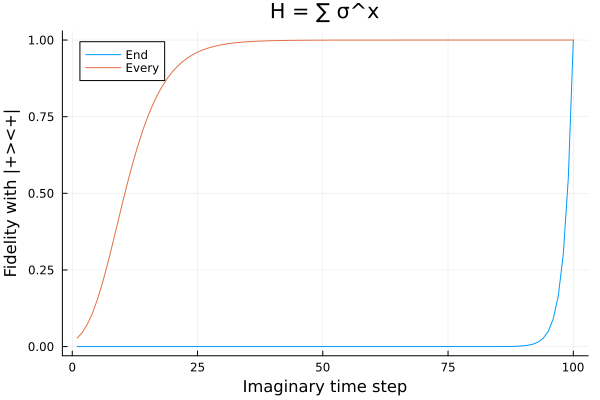

attempt to save state beyond implementation limit


In [183]:
plot(overlapsEnd, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="End", title="H = ∑ σ^x")
plot!(overlapsEvery, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="Every", title="H = ∑ σ^x")


In [63]:
using LinearAlgebra

In [64]:
function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

ZMatrix (generic function with 1 method)

In [106]:
function imaginaryTimeEvolution(nqubits::Int, h::Matrix, beta::Float64)
    operator = exp(-beta/2*h)*I(2^nqubits)*exp(-beta/2*h)/(2^nqubits)
    return operator/tr(exp(-beta*h))*(2^nqubits)
end

function imaginaryTimeEvolutionState(nqubits::Int, h::Matrix, beta::Float64, state::Vector)
    operator = exp(-beta*h)*state
    return operator/LinearAlgebra.norm(operator)
end

imaginaryTimeEvolutionState (generic function with 1 method)

In [175]:
#H = kron(XMatrix(1, 1),XMatrix(1, 1),XMatrix(1, 1))
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
end


In [176]:
state = [1; 1]/sqrt(2)
state = kron(state, state, state, state, state, state)

finalDensity = imaginaryTimeEvolution(6, H, -100.0)
println(tr(finalDensity))
display(finalDensity)
println(state'*finalDensity*state)


64×64 Matrix{Float64}:
 0.015625  0.015625  0.015625  0.015625  …  0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625  …  0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 ⋮                                       ⋱                      
 0.015625  0.015625  0.015625  0.015625  …  0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015

0.9999999999999999
0.9999999999999989


In [173]:
using LaTeXStrings

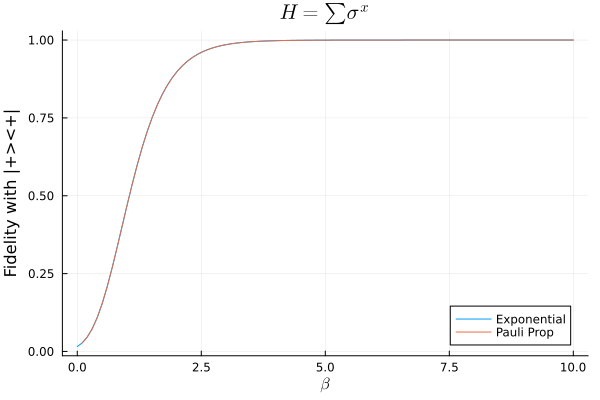

In [184]:
nq = 6
beta2 = LinRange(0, 10, 100)
overlap = Float64[]
for i in beta2
    density = imaginaryTimeEvolution(nq, H, -i)
    push!(overlap, state'*density*state)
end

plot(beta2, overlap, ylabel="Fidelity with |+><+|", xlabel=L"\beta", label="Exponential", title=L"H = \sum \sigma^x")
plot!(beta, overlapsEvery, ylabel="Fidelity with |+><+|", xlabel=L"\beta", label="Pauli Prop", title=L"H = \sum \sigma^x")
